# Predicción del Precio de Bitcoin

En este notebook, vamos a realizar un análisis y predicción del precio de Bitcoin utilizando un modelo de Random Forest. A continuación, se detallan los pasos que seguiremos:

1. **Importación de Librerías**: Importaremos las librerías necesarias para el análisis y la predicción.
2. **Carga de Datos**: Cargaremos el dataset de precios históricos de Bitcoin.
3. **Preprocesamiento de Datos**: Realizaremos la limpieza y transformación de los datos, incluyendo la conversión de fechas y la creación de nuevas características.
4. **División de Datos**: Dividiremos los datos en conjuntos de entrenamiento y prueba.
5. **Entrenamiento del Modelo**: Entrenaremos un modelo de Random Forest utilizando una búsqueda de cuadrícula para encontrar los mejores hiperparámetros.
6. **Evaluación del Modelo**: Evaluaremos el rendimiento del modelo utilizando métricas como el MSE y el RMSE.
7. **Predicción para el Día Siguiente**: Realizaremos una predicción del precio de Bitcoin para el día siguiente.
8. **Visualización de Resultados**: Graficaremos los resultados obtenidos para una mejor interpretación.

Este análisis nos permitirá entender mejor el comportamiento del precio de Bitcoin y realizar predicciones basadas en datos históricos.

## Importación de Librerías

En esta sección, importamos las librerías necesarias para el análisis y la predicción del precio de Bitcoin. Utilizaremos pandas para la manipulación de datos, matplotlib para la visualización, y scikit-learn para el modelado y evaluación del modelo de Random Forest.

Las librerías importadas son:
- pandas
- matplotlib.pyplot
- sklearn.ensemble.RandomForestRegressor
- sklearn.model_selection.train_test_split
- sklearn.model_selection.GridSearchCV
- sklearn.metrics.mean_squared_error
- sklearn.model_selection.TimeSeriesSplit
- warnings

In [1]:
# Importar librerías necesarias
import snscrape.modules.twitter as sntwitter
import pandas as pd
from textblob import TextBlob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
# Deshabilitar el uso de la GPU
tf.config.set_visible_devices([], 'GPU')

2025-01-22 02:49:44.083704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737510584.103308   36707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737510584.109279   36707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 02:49:44.129164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carga de Datos

En esta sección, cargamos el dataset de precios históricos de Bitcoin. Utilizamos la función `read_csv` de pandas para leer el archivo CSV que contiene los datos. A continuación, mostramos un resumen de la estructura del dataframe cargado.

In [2]:
# Cargar datos
df = pd.read_csv('DatosXRP.csv', delimiter=',')
df = df[['Fecha', 'Último', 'Vol.', '% var.']]
df.head()

,Fecha,Último,Vol.,% var.
0,21.01.2021,"0,2681","1,63B","-9,21%"
1,22.01.2021,"0,2726","1,49B","1,68%"
2,23.01.2021,"0,2717","798,56M","-0,35%"
3,24.01.2021,"0,2732","645,08M","0,57%"
4,25.01.2021,"0,2676","837,93M","-2,06%"


## Limpieza y Preprocesamiento de Datos

En esta sección, convertimos las fechas a un formato adecuado, limpiamos los valores numéricos y calculamos nuevas características para el modelo. A continuación, se detallan los pasos realizados:

1. **Conversión de Fechas**: Las fechas se convierten al formato `datetime` y se ordenan cronológicamente.
2. **Limpieza de Columnas Numéricas**: Se reemplazan los puntos por comas y se eliminan los separadores de miles para convertir las columnas numéricas a tipo `float`.
3. **Limpieza y Conversión de la Columna de Volumen**: Se convierten los valores de volumen en 'K', 'M', 'B' a valores numéricos.
4. **Creación de Nuevas Características**: Se crean nuevas características como el rango (diferencia entre el máximo y el mínimo) y el cambio (diferencia entre el último y la apertura).
5. **Conversión de Fechas a Número Ordinal**: Las fechas se convierten a números ordinales para ser utilizadas como características en el modelo.

Estas transformaciones son esenciales para preparar los datos antes de entrenar el modelo de predicción.

In [3]:
# Convertir fecha a formato datetime y ordenar por fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y', errors='coerce')
df = df.sort_values(by='Fecha')

# Limpieza y conversión de la columna de Volumen
df['Vol.'] = (
    df['Vol.']
    .str.replace('K', '*1e3', regex=False)  # Miles
    .str.replace('M', '*1e6', regex=False)  # Millones
    .str.replace('B', '*1e9', regex=False)  # Miles de millones
    .str.replace('.', '', regex=False)  # Eliminar puntos
    .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
    .map(eval)  # Evaluar las expresiones matemáticas
)

df['% var.'] = df['% var.'].str.replace('%', '').str.replace(',', '.').astype(float) / 100

# Limpieza de columnas numéricas
for col in ['Último']:
    df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

In [4]:
df.head()

,Fecha,Último,Vol.,% var.
0,2021-01-21,0.2681,1.630000e+09,-0.0921
1,2021-01-22,0.2726,1.490000e+09,0.0168
2,2021-01-23,0.2717,7.985600e+08,-0.0035
3,2021-01-24,0.2732,6.450800e+08,0.0057
4,2021-01-25,0.2676,8.379300e+08,-0.0206


In [5]:
df.tail()

,Fecha,Último,Vol.,% var.
1456,2025-01-17,3.2914,3.872600e+08,0.0150
1457,2025-01-18,3.2698,4.898800e+08,-0.0066
1458,2025-01-19,2.9601,1.410000e+09,-0.0947
1459,2025-01-20,3.1027,1.950000e+09,0.0482
1460,2025-01-21,3.1735,8.482400e+08,0.0228


In [6]:
# Verificar valores nulos
valores_nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(valores_nulos)

# Verificar duplicados
duplicados = df.duplicated()
df_duplicados = df[duplicados]
print(f"Total de filas duplicadas: {duplicados.sum()}")

Valores nulos por columna:
Fecha     0
Último    0
Vol.      0
% var.    0
dtype: int64
Total de filas duplicadas: 0


## Análisis de Sentimientos

In [7]:
# Crear una lista con las noticias
noticias = [
    {
        "Fecha": "2025-01-20",
        "Titulo": "Increase in XRP trading volume",
        "Contenido": "Recently, the trading volume of XRP has surpassed that of Bitcoin on platforms like Coinbase, indicating growing investor interest in this cryptocurrency.",
        "Fuente": "criptonoticias.com"
    },
    {
        "Fecha": "2025-01-19",
        "Titulo": "Launch of XRP ETP in Europe",
        "Contenido": "The American manager WisdomTree has launched the 'WisdomTree Physical XRP ETP' on several European exchanges.",
        "Fuente": "cincodias.elpais.com"
    },
    {
        "Fecha": "2025-01-20",
        "Titulo": "XRP price falls. Trump's return could generate more volatility for cryptocurrencies.",
        "Contenido": "The price of XRP, a cryptocurrency used on Ripple Labs' digital payments platform, fell 4.8% to $3.09 due to concerns that President Donald Trump's return to the White House could introduce greater volatility in the market. This follows significant gains for XRP since Trump's election, driven by expectations of reduced regulation of digital assets. Trump has nominated Paul Atkins, a crypto-friendly figure, to head the SEC, which could end its legal battle with Ripple once approved by the Senate. However, the market was disappointed by the absence of an executive order to establish a strategic Bitcoin reserve on Trump's inaugural day. While Trump's promises may lead to a rise in cryptocurrency markets, analysts warn investors to be cautious due to the inherent volatility of digital assets.",
        "Fuente": "barrons.com"
    },
    {
        "Fecha": "2025-01-19",
        "Titulo": "XRP price rises. What does Trump mean for cryptocurrencies?",
        "Contenido": "The price of XRP increased on Monday due to anticipation in the crypto world over Donald Trump's return to the White House. XRP rose 8.7% in the last 24 hours, reaching $3.33. Since Trump's election victory, XRP has risen more than 500% and is now the third most valuable cryptocurrency, after Bitcoin and Ether. This increase is due to rumors about its inclusion in the US cryptocurrency reserve. It is also expected that the Securities and Exchange Commission (SEC), with the nomination of Paul Atkins, will drop its pursuit of Ripple, the payment platform that uses XRP. Trump has also launched his own meme coin, which has generated controversy in the crypto community. Bitcoin has also shown growth, nearing another record, trading at $108,201, while Ether rose 6.2% and Solana fell 9.8% after reaching new highs over the weekend.",
        "Fuente": "barrons.com"
    },
    {
        "Fecha": "2025-01-15",
        "Titulo": "XRP reaches an all-time high above $3. Now targeting the range above $4.",
        "Contenido": "XRP, the third-largest cryptocurrency by market capitalization, reached an all-time high of $3.02 on January 15, 2025. The increase was driven by investor optimism around the ongoing legal battle between Ripple Labs Inc., the developer of XRP, and the Securities and Exchange Commission (SEC). The SEC's lawsuit against Ripple Labs, filed in 2020, alleged that XRP was illegally sold as an unregistered digital asset security. However, a federal judge ruled in July 2023 that XRP is not a security when sold to the general public on digital asset exchanges, although sales to institutional investors are considered unregistered securities transactions. With the imminent return of President-elect Donald Trump to office and possible changes in SEC leadership favoring the crypto sector, there is hope that the case may be dismissed. Technically, XRP's rise could reach a target of $4.40, based on a Fibonacci extension pattern, according to analyst Alex Kuptsikevich.",
        "Fuente": "marketwatch.com"
    },
    {
        "Fecha": "2025-01-14",
        "Titulo": "XRP reaches an all-time high above $5. Now targeting the range above $10.",
        "Contenido": "XRP reached an all-time high, the third-largest cryptocurrency has risen",
        "Fuente": "marketwatch.com"
    },
]

# Convertir la lista en un DataFrame
df_noticias = pd.DataFrame(noticias)

# Guardar en un archivo CSV para futuras referencias
df_noticias.to_csv("noticias_xrp.csv", index=False)

# Mostrar el DataFrame
print(df_noticias.head())


        Fecha                                             Titulo  \
0  2025-01-20                     Increase in XRP trading volume   
1  2025-01-19                        Launch of XRP ETP in Europe   
2  2025-01-20  XRP price falls. Trump's return could generate...   
3  2025-01-19  XRP price rises. What does Trump mean for cryp...   
4  2025-01-15  XRP reaches an all-time high above $3. Now tar...   

                                           Contenido                Fuente  
0  Recently, the trading volume of XRP has surpas...    criptonoticias.com  
1  The American manager WisdomTree has launched t...  cincodias.elpais.com  
2  The price of XRP, a cryptocurrency used on Rip...           barrons.com  
3  The price of XRP increased on Monday due to an...           barrons.com  
4  XRP, the third-largest cryptocurrency by marke...       marketwatch.com  


- El modelo fue entrenado con las siguientes etiquetas: "Bajista": 0, "Neutral": 1, "Alcista": 2

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch

tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")
model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert")

# Función para preprocesar y obtener el análisis de sentimiento
def analizar_sentimiento_crypto(texto):
    # Tokenización del texto
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Pasar los datos al modelo
    outputs = model(**inputs)
    
    # Calcular las probabilidades usando softmax
    probs = softmax(outputs.logits, dim=-1)
    
    # Obtener la clase con mayor probabilidad
    return torch.argmax(probs).item()

In [9]:
# Aplicar el análisis de sentimiento a todo el DataFrame
df_noticias['Sentimiento'] = df_noticias['Contenido'].apply(analizar_sentimiento_crypto)

# Ver los resultados
print(df_noticias[['Contenido', 'Sentimiento']])

                                           Contenido  Sentimiento
0  Recently, the trading volume of XRP has surpas...            2
1  The American manager WisdomTree has launched t...            1
2  The price of XRP, a cryptocurrency used on Rip...            2
3  The price of XRP increased on Monday due to an...            2
4  XRP, the third-largest cryptocurrency by marke...            2
5  XRP reached an all-time high, the third-larges...            2


Analizar los Resultados

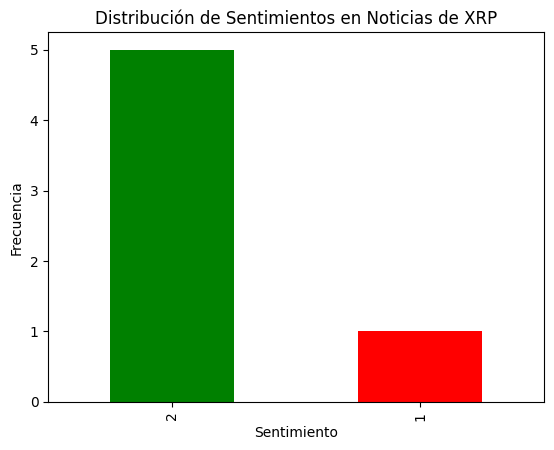

In [10]:
import matplotlib.pyplot as plt

# Visualizar la distribución de sentimientos
df_noticias["Sentimiento"].value_counts().plot(kind="bar", color=["green", "red", "blue"])
plt.title("Distribución de Sentimientos en Noticias de XRP")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.show()


Implementación del modelo LSTM

Preparación de datos para LSTM:
Transformamos los datos para que puedan ser utilizados por el modelo LSTM

In [11]:
# Convertir las columnas 'Fecha' a tipo datetime si no lo están
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_noticias['Fecha'] = pd.to_datetime(df_noticias['Fecha'])

# Merge sentiment analysis results into the main DataFrame
df = df.merge(df_noticias[['Fecha', 'Sentimiento']], on='Fecha', how='left')
df

,Fecha,Último,Vol.,% var.,Sentimiento
0,2021-01-21,0.2681,1.630000e+09,-0.0921,NaN
1,2021-01-22,0.2726,1.490000e+09,0.0168,NaN
2,2021-01-23,0.2717,7.985600e+08,-0.0035,NaN
3,2021-01-24,0.2732,6.450800e+08,0.0057,NaN
4,2021-01-25,0.2676,8.379300e+08,-0.0206,NaN
...,...,...,...,...,...
1458,2025-01-19,2.9601,1.410000e+09,-0.0947,1.0
1459,2025-01-19,2.9601,1.410000e+09,-0.0947,2.0
1460,2025-01-20,3.1027,1.950000e+09,0.0482,2.0
1461,2025-01-20,3.1027,1.950000e+09,0.0482,2.0


In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Seleccionamos las características relevantes
features = df[['Último', 'Vol.', '% var.', 'Sentimiento']]

# Escalamos los datos
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Preparamos los datos para la secuencia de LSTM (ventanas de tiempo)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])
        y.append(data[i + time_step, 0])  # Predecir el precio 'Último'
    return np.array(X), np.array(y)

time_step = 30  # Usamos los últimos 30 días para predecir el siguiente día
X, y = create_dataset(scaled_features, time_step)


Construcción y entrenamiento del modelo LSTM

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Crear el modelo
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Salida con el valor predicho

model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X, y, epochs=50, batch_size=32)


Epoch 1/50


I0000 00:00:1737510595.163912   36847 service.cc:148] XLA service 0x7f53cc02a560 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737510595.164307   36847 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-01-22 02:49:55.250262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 8/45 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: nan

I0000 00:00:1737510596.301308   36847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: nan
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: nan
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: nan
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: nan
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: nan
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: nan
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: nan
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 

Evaluación y predicción:
Evalúa el modelo y realiza predicciones para el próximo día

In [16]:
# Predicción para el siguiente día
predicted_price = model.predict(X[-1].reshape(1, time_step, X.shape[2]))

# Crear un array de ceros con la misma cantidad de características que los datos originales
placeholder = np.zeros((predicted_price.shape[0], scaled_features.shape[1]))

# Colocar el precio predicho en la primera columna del array de ceros
placeholder[:, 0] = predicted_price[:, 0]

# Desescalar
predicted_price = scaler.inverse_transform(placeholder)

# Imprimir el precio predicho
print(f"Precio predicho para el siguiente día: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Precio predicho para el siguiente día: nan


5. Evaluación del modelo:
Métricas a evaluar:
MSE, RMSE, MAE para medir el error de las predicciones.
Gráfico de predicciones vs. valores reales para ver si el modelo captura bien las tendencias.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')


## Selección de características y división de los datos

En esta sección, creamos las variables independientes (X) y la dependiente (y). Luego, dividimos los datos en conjuntos de entrenamiento y prueba.

### Variables Independientes (X)
Las variables independientes seleccionadas son:
- `Fecha_ordinal`: La fecha convertida a un número ordinal.
- `Apertura`: El precio de apertura del Bitcoin.
- `Máximo`: El precio máximo del Bitcoin en el día.
- `Mínimo`: El precio mínimo del Bitcoin en el día.
- `Vol.`: El volumen de transacciones del Bitcoin.
- `Rango`: La diferencia entre el precio máximo y mínimo del día.
- `Cambio`: La diferencia entre el precio de cierre y el de apertura del día.

### Variable Dependiente (y)
La variable dependiente es:
- `Último`: El precio de cierre del Bitcoin.

### División de los Datos
Dividimos los datos en conjuntos de entrenamiento y prueba utilizando una proporción de 80% para entrenamiento y 20% para prueba. Esto nos permite entrenar el modelo con la mayoría de los datos y evaluar su rendimiento con un conjunto de datos no vistos durante el entrenamiento.


In [155]:
# Crear las variables independientes y dependiente
X = df[['Fecha_ordinal', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', 'Rango', 'Cambio']]
y = df['Último']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Verificar las dimensiones de los conjuntos
print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}, y_test: {y_test.shape}")

KeyError: "['Fecha_ordinal', 'Apertura', 'Máximo', 'Mínimo', 'Rango', 'Cambio'] not in index"

## Ajuste del Modelo Random Forest con GridSearchCV

En esta sección, ajustamos los hiperparámetros del modelo Random Forest utilizando GridSearchCV con validación cruzada.

### Explicación

- **GridSearchCV**: Utilizamos GridSearchCV para realizar una búsqueda exhaustiva sobre un conjunto de hiperparámetros especificados. Esto nos permite encontrar la mejor combinación de hiperparámetros para nuestro modelo.
- **RandomForestRegressor**: El modelo de Random Forest que estamos ajustando.
- **TimeSeriesSplit**: Utilizamos TimeSeriesSplit para realizar la validación cruzada, ya que estamos trabajando con datos de series temporales.
- **Parámetros**: Definimos una cuadrícula de hiperparámetros (`param_grid`) que incluye el número de estimadores, la profundidad máxima de los árboles, el número mínimo de muestras para dividir un nodo, el número mínimo de muestras en una hoja y el número de características a considerar para la mejor división.

### Código

In [51]:
# Definición del grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configuración de la validación cruzada para series temporales
tscv = TimeSeriesSplit(n_splits=5)

# Ajustar el modelo con GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=44),
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Guardar el mejor modelo encontrado
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

## Evaluación del Modelo

En esta sección, evaluamos el modelo ajustado en el conjunto de prueba y calculamos las métricas MSE y RMSE.

### Explicación

- **MSE (Mean Squared Error)**: El error cuadrático medio es una métrica que mide el promedio de los errores al cuadrado. Es útil para entender la magnitud de los errores de predicción.
- **RMSE (Root Mean Squared Error)**: La raíz del error cuadrático medio es la raíz cuadrada del MSE. Proporciona una medida de error en las mismas unidades que la variable objetivo, lo que facilita su interpretación.

### Código


In [52]:
# Evaluar el modelo en el conjunto de prueba
y_pred_rf = best_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5

print(f"Error cuadrático medio (MSE): {mse_rf}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_rf}")

Error cuadrático medio (MSE): 0.0025976343006964063
Raíz del error cuadrático medio (RMSE): 0.050966992266528795


## Predicción del Precio del Siguiente Día

### Explicación

En esta sección, realizamos una predicción para el siguiente día utilizando los datos más recientes del dataset. Utilizamos el modelo de Random Forest ajustado previamente para predecir el precio de cierre del Bitcoin para el día siguiente.

### Código


In [53]:
# Predicción para el siguiente día
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = pd.DataFrame({
    'Fecha_ordinal': [proxima_fecha_ordinal],
    'Apertura': [df['Apertura'].iloc[-1]],
    'Máximo': [df['Máximo'].iloc[-1]],
    'Mínimo': [df['Mínimo'].iloc[-1]],
    'Vol.': [df['Vol.'].iloc[-1]],
    'Rango': [df['Rango'].iloc[-1]],
    'Cambio': [df['Cambio'].iloc[-1]]
})

precio_predicho_rf = best_model.predict(entrada_prediccion)[0]
print(f"El precio predicho de XRP para el día {proxima_fecha.date()} es: {precio_predicho_rf:.2f}")

El precio predicho de XRP para el día 2025-01-17 es: 3.08


## Visualización de Resultados

### Explicación

En esta sección, creamos gráficos para comparar los datos reales con las predicciones del modelo y marcamos el valor predicho para el siguiente día. Esto nos permite visualizar el rendimiento del modelo y evaluar la precisión de las predicciones.

### Código


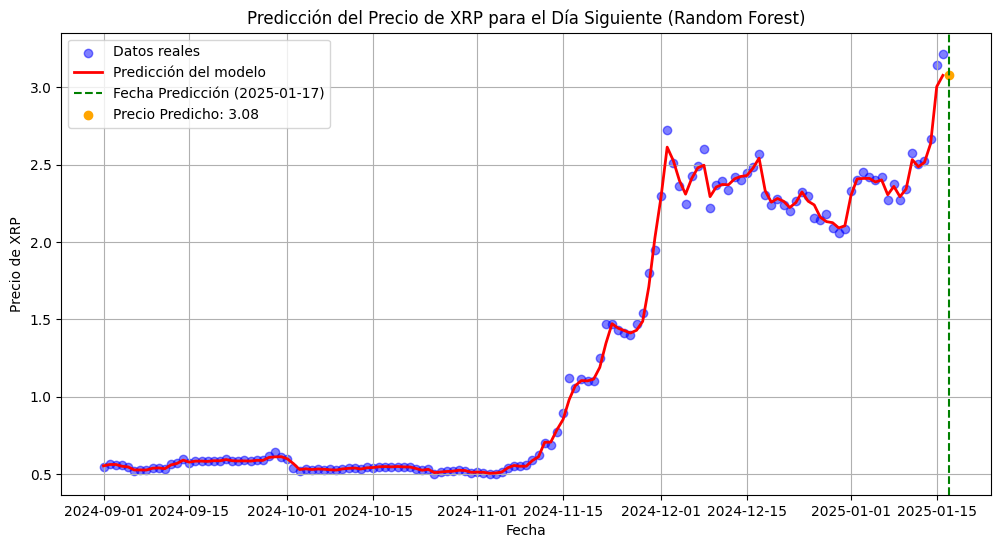

In [54]:
# Gráfica de resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Último'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas_rf = best_model.predict(X)
plt.plot(df['Fecha'], predicciones_historicas_rf, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho_rf, color='orange', label=f'Precio Predicho: {precio_predicho_rf:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de XRP')
plt.title('Predicción del Precio de XRP para el Día Siguiente (Random Forest)')
plt.legend()
plt.grid()
plt.show()

## Evaluación Adicional del Modelo

Esta sección nos ayuda a:

- **Verificar la consistencia del modelo con validación cruzada**: Utilizamos la métrica de MSE promedio en múltiples divisiones del dataset para evaluar la estabilidad del modelo.
- **Evaluar la precisión de las predicciones del modelo**: Calculamos el MAE para entender el error promedio de las predicciones del modelo.

### Métricas de Evaluación

- **MSE (Mean Squared Error)**: El error cuadrático medio mide el promedio de los errores al cuadrado. Es útil para entender la magnitud de los errores de predicción.
- **MAE (Mean Absolute Error)**: El error absoluto medio mide el promedio de los errores absolutos. Es útil para entender la precisión de las predicciones del modelo.

Estas métricas complementan las evaluaciones anteriores, proporcionando una visión más completa del rendimiento del modelo.

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)
print("MSE promedio:", -scores.mean())

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Error absoluto medio (MAE): {mae_rf}")

MSE promedio: 0.01779014552051384
Error absoluto medio (MAE): 0.03179210714285683


## Verificación de Datos

Al final del proceso de modelado, utilizamos `df.info()` para verificar que todos los datos están correctamente cargados y que no hay ningún dato faltante. Esta función proporciona un resumen conciso del DataFrame, incluyendo el número de entradas, el nombre de las columnas, el tipo de datos de cada columna y el número de valores no nulos.

### Explicación

- **Número de Entradas**: Indica la cantidad total de filas en el DataFrame.
- **Nombre de las Columnas**: Lista los nombres de todas las columnas presentes en el DataFrame.
- **Tipo de Datos**: Muestra el tipo de datos de cada columna (por ejemplo, `int64`, `float64`, `datetime64[ns]`, etc.).
- **Valores No Nulos**: Indica cuántos valores no nulos hay en cada columna, lo que es útil para identificar columnas con datos faltantes.
- **Uso de Memoria**: Proporciona una estimación del uso de memoria del DataFrame.

Este paso es para asegurarnos de que los datos están en el formato correcto.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 137 to 0
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          138 non-null    datetime64[ns]
 1   Último         138 non-null    float64       
 2   Apertura       138 non-null    float64       
 3   Máximo         138 non-null    float64       
 4   Mínimo         138 non-null    float64       
 5   Vol.           138 non-null    float64       
 6   % var.         138 non-null    object        
 7   Rango          138 non-null    float64       
 8   Cambio         138 non-null    float64       
 9   Fecha_ordinal  138 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 11.9+ KB
